In [1]:
# default_exp analyses

# The Lag-Contiguity Effect in Repetition Data
The lag-contiguity effect illustrates how episodic associations are graded, exhibiting power-function decay with increasing lag. 
Recall of an item has a tendency to evoke not only adjacent list items, but other nearby items as well. 
In addition, episodic associations appear to be a|symmetrical, favoring retrieval of items in the forward order.

Here we extend on previous implementations to ensure recall rates are successfully measured and visualized when study lists can include two presentations of study items. 

## Contrast With Stochastic Approach Demoed in Lohnas & Kahana (2014)

> For lists containing repeated spaced items, the lags for such an item is ambiguous. For instance, the transition between an item presented in serial position 5 to an item presented in serial positions 3 and 9 could be considered a lag of −2 or +4. 

I kind of disagree with the specifics of this framework. The lags are not ambiguous -- we know what they are. Rather, they are numerous, and to account for that we can just track each lag in our analysis.

> For any transition with an ambiguous lag (i.e. a transition including a repeated item), we randomly selected the lag value from the set of possible lags. 

The lag-CRP is a ratio of lag transitions that were made over transitions that could have been made across each output in a dataset. However, for lists containing repeated spaced items, the lags for such an item is numerous. For instance, the transition between an item presented in serial position 5 to an item presented in serial positions 3 and 9 is both a lag of −2 and of +4. In our tally of actual and possible lag transitions, we accordingly count both these values. Relating this approach to the example above, a lag transition of -2 and of +4 is possible (and actual) for the considered output.

Randomly selecting the lag value from the set of possible lags for each analysis and aggregating over multiple replicates will (probably) converge to this result. However, that approach is imprecise, nondeterministic, and takes longer to run.

## Function
This version is specially designed to support lists with more than 2 item presentation. See `compmemlearn.flex_lag_crp`.

<!--TODO: though I may have not tested it for this case yet).
-->

In [2]:
from repetition_cmr.analyses import recall_by_all_study_positions

In [3]:
# export

from numba import njit
import numpy as np

@njit(nogil=True)
def lag_crp(trials, presentations, max_repeats=3):
    
    list_length = len(presentations[0])
    lag_range = list_length - 1
    total_actual_lags = np.zeros(lag_range * 2 + 1)
    total_possible_lags = np.zeros(lag_range * 2 + 1)
    terminus = np.sum(trials != 0, axis=1) # number of recalls per trial
    recall_by_study_position = recall_by_all_study_positions(trials, presentations, max_repeats)
    
    for trial_index in range(len(trials)):
        
        previous_item = 0
        item_count = np.max(presentations[trial_index]) + 1
        possible_items = np.arange(item_count) # initial pool of possible recalls, 1-indexed
        possible_positions = np.zeros((item_count, max_repeats), dtype=np.int32)
        
        # we track possible positions using presentations and alt_presentations
        for item in range(item_count):
            pos = np.nonzero(presentations[trial_index] == item)[0] + 1
            possible_positions[item, :len(pos)] = pos
            
        for recall_index in range(terminus[trial_index]):
            
            current_item = presentations[trial_index][trials[trial_index, recall_index]-1]
            
            # track possible and actual lags
            if recall_index > 0:
                
                # item indices don't help track lag s anymore
                # so more complex calculation needed to identify possible lags given previous item
                current_index = np.nonzero(possible_items==current_item)[0]
                possible_lags = np.zeros((len(recall_by_study_position) ** 2, len(possible_items)), dtype=np.int32)

                index = 0
                for x in range(len(recall_by_study_position)):
                    for y in range(len(recall_by_study_position)):
                        if possible_positions[previous_item, y] > 0:
                        
                            possible_lags[index] = possible_positions[
                                possible_items, x] - possible_positions[previous_item, y]
                            
                            # if tracked position is 0, then we don't actually want to count it in our lags
                            possible_lags[index][possible_positions[possible_items, x] == 0] = 0
                        
                        index += 1

                possible_lags += lag_range
                total_actual_lags[possible_lags[:, current_index].flatten()] += 1
                total_possible_lags[possible_lags.flatten()] += 1
                        

            # update pool to exclude recalled item (updated to still identify 1-indexed item)
            previous_item = current_item
            possible_items = possible_items[possible_items != previous_item]
                    
    # small correction to avoid nans and commit to excluding multiply-tracked single presentations 
    total_actual_lags[lag_range] = 0
    total_possible_lags[total_actual_lags==0] += 1
    
    return total_actual_lags/total_possible_lags

In [9]:
# export

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from compmemlearn.datasets import events_metadata, generate_trial_mask


def plot_crp(data, trial_query, contrast_name='', labels=None, axis=None, max_lag=3):

    if axis is None:
        plt.figure()
        axis = plt.gca()

    if labels is None:
        labels = [''] * len(data)

    result = []
    for data_index, events in enumerate(data):

        # generate and subset trials array and list of list_lengths based on trial_query
        trials, list_lengths, presentations = events_metadata(events)
        trial_mask = generate_trial_mask(events, trial_query)
        chose = [i for i in range(len(trial_mask)) if np.sum(trial_mask[i]) != 0]
        assert(len(chose) == 1)
        chose = chose[0]
        trials = trials[chose]
        list_length = list_lengths[chose]
        presentations = presentations[chose]
        trial_mask = trial_mask[chose]

        lag_interval = np.arange(-max_lag, max_lag+1)
        list_length = list_lengths[0]
        lag_range = list_length -1
        for subject in pd.unique(events.subject):
            subject_specific_trial_mask = np.logical_and(
                generate_trial_mask(events, f"subject == {subject}")[chose], trial_mask
            )

            if np.sum(subject_specific_trial_mask) == 0:
                continue
            res = lag_crp(trials[subject_specific_trial_mask], presentations[subject_specific_trial_mask])
            if np.sum(res) == 0:
                continue
            res[lag_range] = np.nan

            result.append(pd.DataFrame.from_dict(
                {
                    "subject": subject,
                    "lag": lag_interval,
                    "prob": res[lag_range-max_lag:lag_range+max_lag+1],
                    contrast_name: labels[data_index],
                }
            ))

    result = pd.concat(result)

    color = None if len(data) == 1 else 'blue'
    filt_neg = f'{-max_lag} <= lag < 0'
    filt_pos = f'0 < lag <= {max_lag}'

    sns.lineplot(ax=axis, data=result.query(filt_neg), x='lag', y='prob', palette='tab10',
                err_style='bars', hue=contrast_name, legend=False, color=color)
    sns.lineplot(ax=axis, data=result.query(filt_pos), x='lag', y='prob', palette='tab10',
                err_style='bars', hue=contrast_name, color=color)
    axis.set(xlabel='Item\'s Lag In Study List From Last Recalled Item', ylabel='Conditional Recall Rate')
    axis.set_xticks(np.arange(-max_lag, max_lag+1, 1))
    #axis.set_ylim((0, 1))

    if contrast_name:
        axis.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    return axis

## Howard & Kahana (2005) Dataset
> Kahana, M. J., & Howard, M. W. (2005). Spacing and lag effects in free recall of pure lists. Psychonomic Bulletin & Review, 12(1), 159-164.

0.05498211557354751

0.07072179152996788

0.07069117062952224



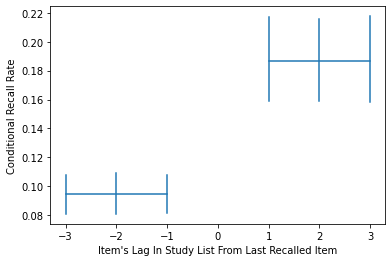

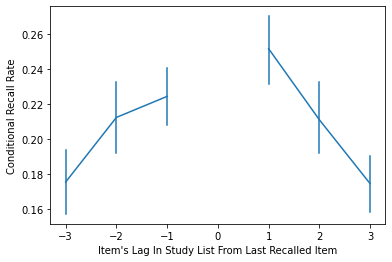

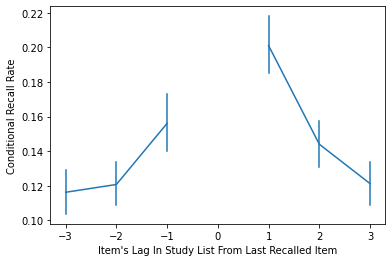

In [10]:
import pandas as pd
from compmemlearn.datasets import events_metadata, generate_trial_mask

events = pd.read_csv('../../../compmemlearn/data/HowardKahana2005.csv')
trials, list_lengths, presentations = events_metadata(events)

for condition in [0, 2, 1]:
    trial_mask = generate_trial_mask(events, f"condition == {condition}")[0]
    print(np.mean(lag_crp(trials[0][trial_mask], presentations[0][trial_mask])))
    plot_crp([events], f"condition == {condition}", contrast_name='', labels=None, axis=None)
    print()

## Lohnas & Kahana (2014) Dataset
> Siegel, L. L., & Kahana, M. J. (2014). A retrieved context account of spacing and repetition effects in free recall. Journal of Experimental Psychology: Learning, Memory, and Cognition, 40(3), 755.

0.025813647450445676

0.07801851762967374

0.08526393816469326

0.03754601064001489



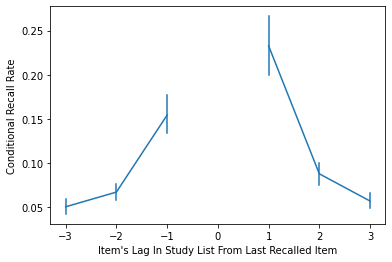

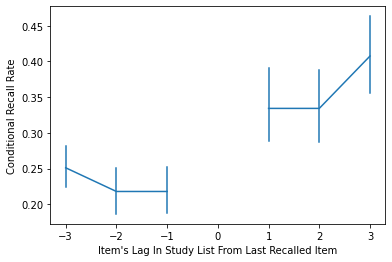

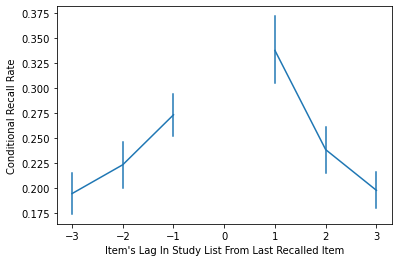

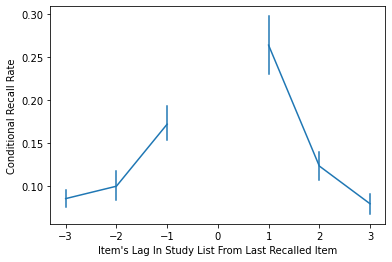

In [11]:
import pandas as pd
from compmemlearn.datasets import events_metadata, generate_trial_mask

events = pd.read_csv('../../../compmemlearn/data/LohnasKahana2014.csv')
trials, list_lengths, presentations = events_metadata(events)

for condition in [1, 2, 3, 4]:
    trial_mask = generate_trial_mask(events, f"condition == {condition}")[0]
    print(np.mean(lag_crp(trials[0][trial_mask], presentations[0][trial_mask])))
    plot_crp([events], f"condition == {condition}", contrast_name='', labels=None, axis=None)
    print()